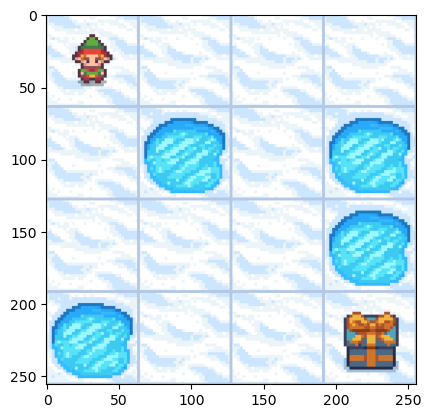

In [13]:
import gym
from matplotlib import pyplot as plt

#创建游戏环境
#is_slippery控制会不会滑
#map_name决定地图的尺寸,还可以取8x8
#desc决定地形
env = gym.make('FrozenLake-v1',
               render_mode='rgb_array',
               is_slippery=False,
               map_name='4x4',
               desc=['SFFF', 'FHFH', 'FFFH', 'HFFG'])
env.reset()

#解封装才能访问状态转移矩阵P
env = env.unwrapped


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [14]:
#查看冰湖这个游戏的状态列表
#一共4*4=16个状态
#每个状态下都可以执行4个动作:{0:↑；1:↓；2:→；3:←}
#每个动作执行完，都有概率得到3个结果
#(0.3333333333333333, 0, 0.0, False)这个数据结构表示(概率，下个状态，奖励，是否结束)
len(env.P), env.P[0]

(16,
 {0: [(1.0, 0, 0.0, False)],
  1: [(1.0, 4, 0.0, False)],
  2: [(1.0, 1, 0.0, False)],
  3: [(1.0, 0, 0.0, False)]})

In [15]:
import numpy as np
#价值矩阵，存储每一个状态的价值
values = np.zeros(16)

#策略矩阵，存储下一步选择动作对应的概率
pi = np.ones([16, 4]) * 0.25

values, pi

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25]]))

In [16]:
# 计算q(s,a)==action value
def QFunc(state, action):
    # 当前状态初始化
    Qvalue = 0.0
    #每个动作都会有三个不同的结果，这里要按概率把他们加权求和
    for prop, next_state, reward, over in env.P[state][action]:
        # Bellman公式，计算下一个状态的价值
        next_value = values[next_state] * 0.9
        # 如果到了终点或陷阱中，则下一个状态分数为0（即停止时）
        if over:
            next_value = 0
        # 一定要分开计算，要不就会到达终点将之前计算的清零
        next_value += reward
        #因为下个状态是概率出现了,所以这里要乘以概率
        Qvalue += next_value * prop

    return Qvalue


In [17]:
# 策略评估，更新values矩阵
def Evaluation(algorithm):
    #初始化一个新的values,重新评估所有格子的分数
    new_values = np.zeros([16])
    # 遍历所有格子，计算每一个格子的状态值
    for state in range(16):
        # 计算当前格子4个动作的分数
        action_value = np.zeros(4)
        # 遍历所有动作
        for action in range(4):
            action_value[action] = QFunc(state, action)
        # 区分值迭代方法和策略迭代方法
        if algorithm == 0:
            #每个动作的分数和它的概率相乘
            action_value *= pi[state]
            #最后这个格子的分数,等于该格子下所有动作的分数求和
            new_values[state] = action_value.sum()
        if algorithm == 1:
            #求每一个格子的分数，等于该格子下所有动作的最大分数
            new_values[state] = action_value.max()
    return new_values

In [18]:
#策略提升，更新pi矩阵
def Update():
    #重新初始化每个格子下采用动作的概率,重新评估
    new_pi = np.zeros([16, 4])

    #遍历所有格子
    for state in range(16):

        #计算当前格子4个动作分别的分数
        action_value = np.zeros(4)

        #遍历所有动作
        for action in range(4):
            action_value[action] = QFunc(state, action)

        #计算当前state下，达到最大分数的动作有几个
        count = (action_value == action_value.max()).sum()

        #让这些动作均分概率
        for action in range(4):
            if action_value[action] == action_value.max():
                new_pi[state, action] = 1 / count
            else:
                new_pi[state, action] = 0

    return new_pi

In [19]:
#循环迭代策略评估和策略提升，寻找最优解
# 迭代10轮
for _ in range(10):
    # 每一轮轨迹长度为100
    for _ in range(100):
        values = Evaluation(1)
    pi = Update()

values, pi

(array([0.59049, 0.6561 , 0.729  , 0.6561 , 0.6561 , 0.     , 0.81   ,
        0.     , 0.729  , 0.81   , 0.9    , 0.     , 0.     , 0.9    ,
        1.     , 0.     ]),
 array([[0.  , 0.5 , 0.5 , 0.  ],
        [0.  , 0.  , 1.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  ],
        [1.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  ],
        [0.25, 0.25, 0.25, 0.25],
        [0.  , 1.  , 0.  , 0.  ],
        [0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 1.  , 0.  ],
        [0.  , 0.5 , 0.5 , 0.  ],
        [0.  , 1.  , 0.  , 0.  ],
        [0.25, 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 1.  , 0.  ],
        [0.  , 0.  , 1.  , 0.  ],
        [0.25, 0.25, 0.25, 0.25]]))

In [20]:
#打印每个格子的策略
def print_pi():
    #遍历所有格子
    for row in range(4):
        line = ''
        for col in range(4):
            state = row * 4 + col
            if (row == 1 and col == 1) or (row == 1 and col == 3) or (
                    row == 2 and col == 3) or (row == 3 and col == 0):
                line += '○'
                continue
            if row == 3 and col == 3:
                line += '❤'
                continue
            #line += '□'
            line += '←↓→↑'[pi[state].argmax()]
        print(line)
print_pi()

↓→↓←
↓○↓○
→↓↓○
○→→❤


In [21]:
from IPython import display
import time


def play():
    env.reset()

    #起点在0
    index = 0

    #最多玩N步
    for i in range(200):
        #选择一个动作
        action = np.random.choice(np.arange(4), size=1, p=pi[index])[0]

        #执行动作
        index, reward, terminated, truncated, _ = env.step(action)

        #打印动画
        display.clear_output(wait=True)
        time.sleep(0.1)
        show()

        #获取当前状态，如果状态是终点或者掉陷阱则终止
        if terminated or truncated:
            break

    print(i)


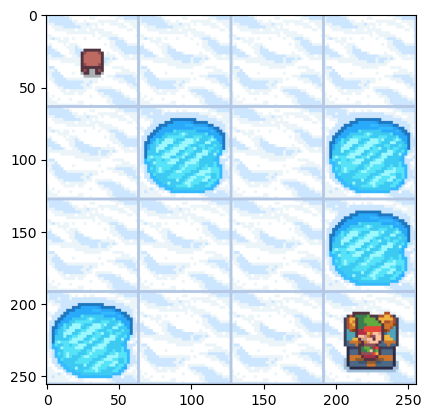

5


In [23]:
play()